In [1]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

from clusterless import preprocess
from clusterless import viz
from clusterless import decoder

### load data

In [2]:
pid = 'dab512bd-a02d-4c1f-8dbc-9155a163efc0'
rootpath = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org'
trial_data_path = rootpath + '/danlab/Subjects/DY_016/2020-09-12/001/alf'
neural_data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_016'
behavior_data_path = rootpath + '/paper_repro_ephys_data/figure9_10/original_data'
save_path = '../saved_results/danlab/Subjects/DY_016/'

In [3]:
behave_dict = preprocess.load_behaviors_data(behavior_data_path, pid)
choices, stimuli, transformed_stimuli, one_hot_stimuli, enc_categories, rewards, priors = preprocess.preprocess_static_behaviors(behave_dict)

choices left: 0.751, right: 0.249
stimuli left: 0.547, right: 0.453
reward wrong: 0.211, correct: 0.789


In [4]:
rois = [roi.lower() for roi in ['PO', 'LP', 'DG', 'CA1', 'VIS']]
roi = rois[0]
print(roi)

po


In [5]:
unsorted_trials, stim_on_times, np1_channel_map = preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi=roi,
    kilosort=False,
    triage=False
)

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
1st trial stim on time: 17.56, last trial stim on time 2310.24
found 163 neurons in region po ...
found 90 channels in region po ...


In [6]:
C = 50
n_time_bins = 10

In [7]:
n_trials = stim_on_times.shape[0]
n_channels = np1_channel_map.shape[0]
spike_times = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)])[:,0]

rand_idx = np.arange(n_trials)
train_idx = rand_idx[:int(.8*n_trials)]
test_idx = rand_idx[int(.8*n_trials):]

train_features = np.vstack([unsorted_trials[i][:,2:] for i in train_idx])
train_labels = choices[train_idx].argmax(1)
test_labels = choices[test_idx].argmax(1)

binning = np.arange(0, 1.5, step=(1.5 - 0)/n_time_bins)
n_trials = stim_on_times.shape[0]
spike_train = np.concatenate(unsorted_trials)[:,[0,2,3,4]]

trial_idx = []
time_idx = []
all_trials = []
for k in range(n_trials):
    mask = np.logical_and(spike_train[:,0] >= stim_on_times[k]-0.5,
                          spike_train[:,0] <= stim_on_times[k]+1
                         )
    trial = spike_train[mask,:]
    trial[:,0] = trial[:,0] - trial[:,0].min()
    time_bins = np.digitize(trial[:,0], binning, right=False)-1
    for t in range(n_time_bins):
        time_bin = trial[time_bins == t, 1:]
        time_idx.append(np.ones_like(time_bin[:,0]) * t)
        trial_idx.append(np.ones_like(time_bin[:,0]) * k)
        all_trials.append(time_bin)
time_idx = np.concatenate(time_idx)
trial_idx = np.concatenate(trial_idx)
all_trials = np.concatenate(all_trials)

train_mask = np.sum([trial_idx == idx for idx in train_idx], axis=0).astype(bool)
train_trials = all_trials[train_mask]
train_time_idx = time_idx[train_mask]
train_trial_idx = trial_idx[train_mask]

test_mask = np.sum([trial_idx == idx for idx in test_idx], axis=0).astype(bool)
test_trials = all_trials[test_mask]
test_time_idx = time_idx[test_mask]
test_trial_idx = trial_idx[test_mask]

### encoder + MoG

In [8]:
res_enc = np.load(save_path + f'cavi_results/res_enc_{roi}_c{C}_t{n_time_bins}.npy', allow_pickle=True).item()
res_dec = np.load(save_path + f'cavi_results/res_dec_{roi}_c{C}_t{n_time_bins}.npy', allow_pickle=True).item()

In [9]:
enc_lams = res_enc['lam']
enc_means = res_enc['mu']
enc_covs = res_enc['cov']

dec_nu = res_dec['nu']
test_pred = (1. * (dec_nu > .5)).astype(int)

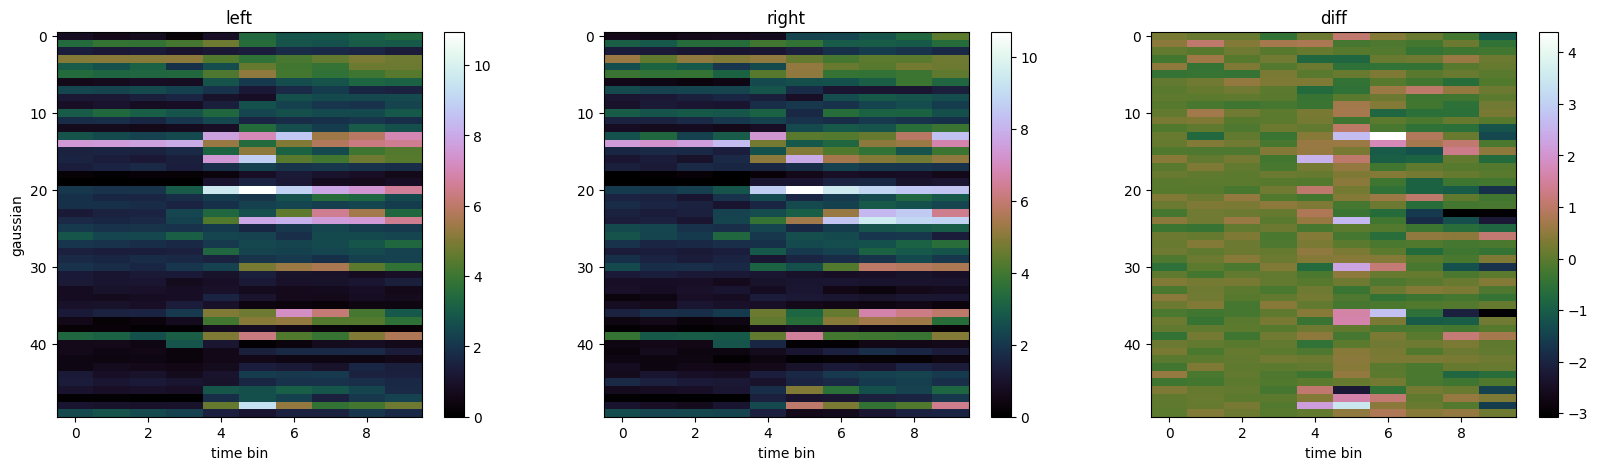

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))
f1 = ax1.imshow(enc_lams[:,:,0], aspect='auto', cmap='cubehelix')
ax1.set_title('left')
ax1.set_xlabel('time bin')
ax1.set_ylabel('gaussian')
fig.colorbar(f1, ax=ax1);
f2 = ax2.imshow(enc_lams[:,:,1], aspect='auto', cmap='cubehelix')
ax2.set_title('right')
ax2.set_xlabel('time bin')
fig.colorbar(f2, ax=ax2);
f3 = ax3.imshow(enc_lams[:,:,0] - enc_lams[:,:,1], aspect='auto', cmap='cubehelix')
ax3.set_title('diff')
ax3.set_xlabel('time bin')
fig.colorbar(f3, ax=ax3);

In [11]:
# compute time-varying pi_jt
enc_pis = enc_lams / enc_lams.sum(0)

In [12]:
enc_pis.shape

(50, 10, 2)

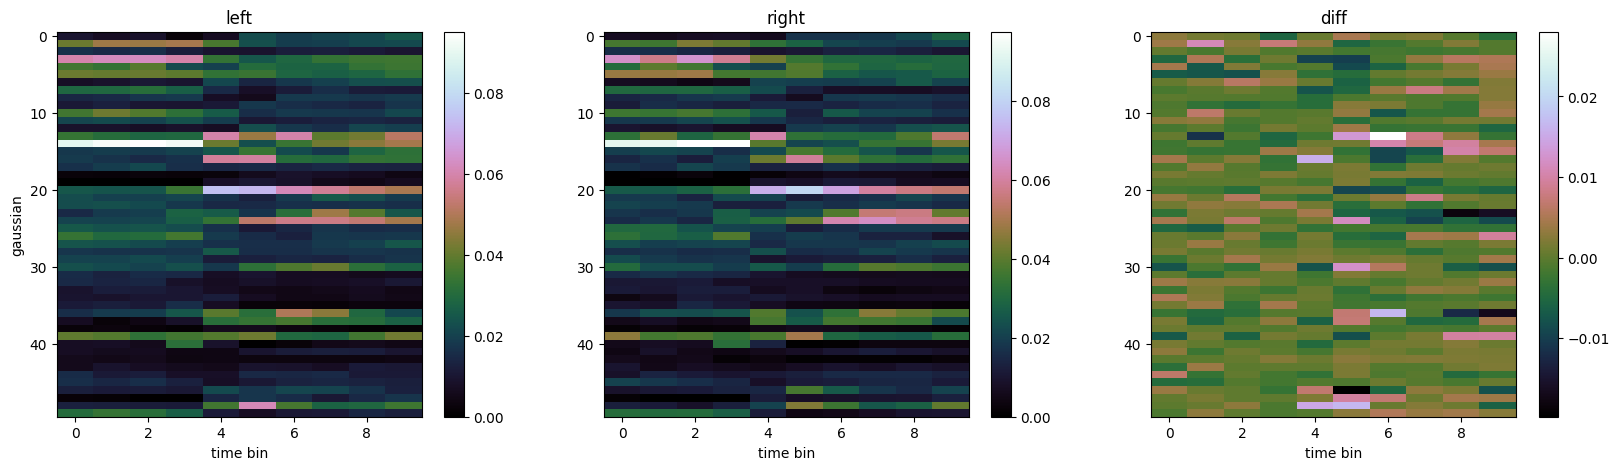

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))
f1 = ax1.imshow(enc_pis[:,:,0], aspect='auto', cmap='cubehelix')
ax1.set_title('left')
ax1.set_xlabel('time bin')
ax1.set_ylabel('gaussian')
fig.colorbar(f1, ax=ax1);
f2 = ax2.imshow(enc_pis[:,:,1], aspect='auto', cmap='cubehelix')
ax2.set_title('right')
ax2.set_xlabel('time bin')
fig.colorbar(f2, ax=ax2);
f3 = ax3.imshow(enc_pis[:,:,0] - enc_pis[:,:,1], aspect='auto', cmap='cubehelix')
ax3.set_title('diff')
ax3.set_xlabel('time bin')
fig.colorbar(f3, ax=ax3);

In [13]:
all_feat = []
for k in range(n_trials):
    mask = np.logical_and(spike_train[:,0] >= stim_on_times[k]-0.5,
                          spike_train[:,0] <= stim_on_times[k]+1
                         )
    trial = spike_train[mask,:]
    trial[:,0] = trial[:,0] - trial[:,0].min()
    time_bins = np.digitize(trial[:,0], binning, right=False)-1
    time_bins_lst = []
    for t in range(n_time_bins):
        time_bin = trial[time_bins == t, 1:]
        time_bins_lst.append(time_bin)
    all_feat.append(time_bins_lst)
train_feat = [all_feat[k] for k in train_idx]
test_feat = [all_feat[k] for k in test_idx]

In [14]:
# compute weight matrix
K = len(train_idx)
T = n_time_bins
W_train = np.zeros((K, T, C))

for k in range(K):
    for t in range(T):
        modulated_gmm =  GaussianMixture(n_components=C, covariance_type='full')
        modulated_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(enc_covs))
        modulated_gmm.weights_ = enc_pis[:, t, train_labels[k]]
        modulated_gmm.means_ = enc_means
        modulated_gmm.covariances_ = enc_covs
        if len(train_feat[k][t]) != 0:
            W_train[k,t,:] = modulated_gmm.predict_proba(train_feat[k][t]).sum(0)
        else:
            W_train[k,t,:] = np.zeros(C)

In [15]:
W_train.shape

(212, 10, 50)

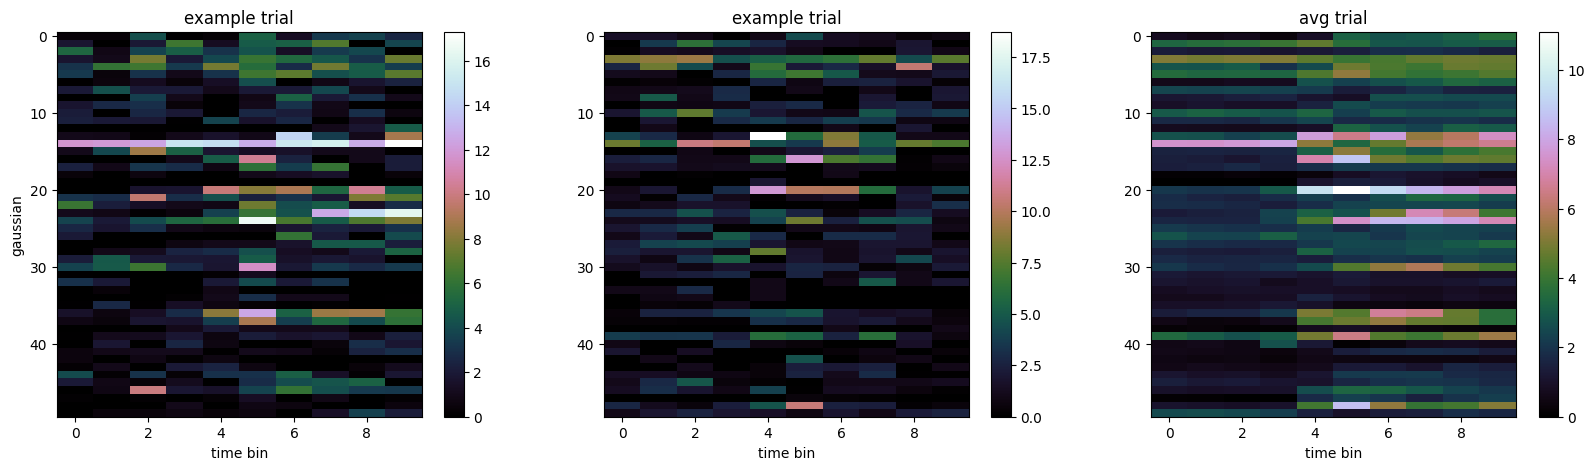

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))
f1 = ax1.imshow(W_train[0].T, aspect='auto', cmap='cubehelix')
ax1.set_title('example trial')
ax1.set_xlabel('time bin')
ax1.set_ylabel('gaussian')
fig.colorbar(f1, ax=ax1);
f2 = ax2.imshow(W_train[100].T, aspect='auto', cmap='cubehelix')
ax2.set_title('example trial')
ax2.set_xlabel('time bin')
fig.colorbar(f2, ax=ax2);
f3 = ax3.imshow(W_train.mean(0).T, aspect='auto', cmap='cubehelix')
ax3.set_title('avg trial')
ax3.set_xlabel('time bin')
fig.colorbar(f3, ax=ax3);

In [16]:
K = len(test_idx)
T = n_time_bins
W_test = np.zeros((K, T, C))

for k in range(K):
    for t in range(T):
        modulated_gmm =  GaussianMixture(n_components=C, covariance_type='full')
        modulated_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(enc_covs))
        modulated_gmm.weights_ = enc_pis[:, t, test_pred[k]]
        modulated_gmm.means_ = enc_means
        modulated_gmm.covariances_ = enc_covs
        if len(test_feat[k][t]) != 0:
            W_test[k,t,:] = modulated_gmm.predict_proba(test_feat[k][t]).sum(0)
        else:
            W_test[k,t,:] = np.zeros(C)

In [19]:
x_train = W_train.reshape(-1, W_train.shape[1]*W_train.shape[-1])
x_test = W_test.reshape(-1, W_test.shape[1]*W_test.shape[-1])
decoder = LogisticRegression(random_state=seed, max_iter=1e4, tol = 0.01,
                            solver='liblinear').fit(x_train, train_labels)
probs = decoder.predict_proba(x_test)
preds = probs.argmax(1)
acc = accuracy_score(test_labels, preds)
auc = roc_auc_score(choices[test_idx], probs)

In [20]:
print(acc)
print(auc)

0.9056603773584906
0.9307692307692308


### encoder + decoder

In [21]:
acc = accuracy_score(test_labels, test_pred)
auc = roc_auc_score(test_labels, dec_nu)

In [22]:
print(acc)
print(auc)

0.9056603773584906
0.9451923076923077


### MoG only

In [17]:
gmm = GaussianMixture(n_components=C, 
                      covariance_type='full', 
                      init_params='k-means++',
                      verbose=1)
gmm.fit(train_trials)

Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True


GaussianMixture(init_params='k-means++', n_components=50, verbose=1)

In [18]:
spike_labels = []
spike_probs = []
spike_labels.extend(gmm.predict(all_trials))
spike_probs.extend(gmm.predict_proba(all_trials))
spike_labels = np.array(spike_labels)
spike_probs = np.array(spike_probs)

In [19]:
clusterless_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_labels, spike_probs),
    stim_on_times,
    'clusterless', 
    n_time_bins=n_time_bins
)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')

clusterless neural data shape: (265, 50, 10)


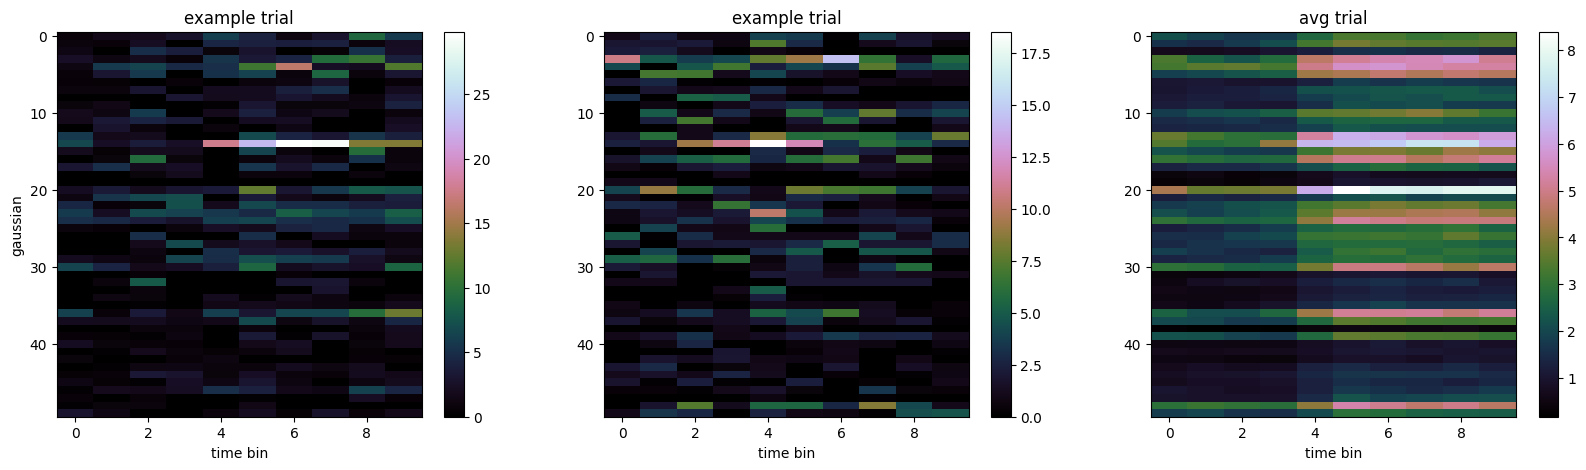

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))
f1 = ax1.imshow(clusterless_neural_data[0], aspect='auto', cmap='cubehelix')
ax1.set_title('example trial')
ax1.set_xlabel('time bin')
ax1.set_ylabel('gaussian')
fig.colorbar(f1, ax=ax1);
f2 = ax2.imshow(clusterless_neural_data[100], aspect='auto', cmap='cubehelix')
ax2.set_title('example trial')
ax2.set_xlabel('time bin')
fig.colorbar(f2, ax=ax2);
f3 = ax3.imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
ax3.set_title('avg trial')
ax3.set_xlabel('time bin')
fig.colorbar(f3, ax=ax3);

In [27]:
x_train = clusterless_neural_data[train_idx].reshape(-1, clusterless_neural_data.shape[1]*clusterless_neural_data.shape[-1])
x_test = clusterless_neural_data[test_idx].reshape(-1, clusterless_neural_data.shape[1]*clusterless_neural_data.shape[-1])
decoder = LogisticRegression(random_state=seed, max_iter=1e4, tol = 0.01,
                            solver='liblinear').fit(x_train, train_labels)
probs = decoder.predict_proba(x_test)
preds = probs.argmax(1)
acc = accuracy_score(test_labels, preds)
auc = roc_auc_score(choices[test_idx], probs)

In [28]:
print(acc)
print(auc)

0.7924528301886793
0.8192307692307692


### sorted and good units

In [29]:
sorted_trials, good_sorted_trials, unsorted_trials, stim_on_times, np1_channel_map= preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi=roi,
    kilosort=True,
    triage=False,
    good_units=True,
    thresholding=True
)

n_trials = stim_on_times.shape[0]
sorted = np.vstack([sorted_trials[i] for i in np.arange(n_trials)]) 
unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)])
spike_times = sorted[:,0]
spike_clusters = sorted[:,1]
spike_channels = unsorted[:,1]

sorted_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30,
    regional=True
)
print(f'sorted neural data shape: {sorted_neural_data.shape}')

good_sorted = np.vstack([good_sorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = good_sorted[:,0]
spike_clusters = good_sorted[:,1]

good_sorted_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30,
    regional=True
)
print(f'good sorted neural data shape: {good_sorted_neural_data.shape}')

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
found 83 good ibl units ..
1st trial stim on time: 17.56, last trial stim on time 2310.24
found 163 neurons in region po ...
found 90 channels in region po ...
sorted neural data shape: (265, 159, 30)
good sorted neural data shape: (265, 24, 30)


In [30]:
x_train = sorted_neural_data[train_idx].reshape(-1, sorted_neural_data.shape[1]*sorted_neural_data.shape[-1])
x_test = sorted_neural_data[test_idx].reshape(-1, sorted_neural_data.shape[1]*sorted_neural_data.shape[-1])
decoder = LogisticRegression(random_state=seed, max_iter=1e4, tol = 0.01,
                            solver='liblinear').fit(x_train, train_labels)
probs = decoder.predict_proba(x_test)
preds = probs.argmax(1)
acc = accuracy_score(test_labels, preds)
auc = roc_auc_score(choices[test_idx], probs)

In [31]:
print(acc)
print(auc)

0.8301886792452831
0.9096153846153846


In [32]:
x_train = good_sorted_neural_data[train_idx].reshape(-1, good_sorted_neural_data.shape[1]*good_sorted_neural_data.shape[-1])
x_test = good_sorted_neural_data[test_idx].reshape(-1, good_sorted_neural_data.shape[1]*good_sorted_neural_data.shape[-1])
decoder = LogisticRegression(random_state=seed, max_iter=1e4, tol = 0.01,
                            solver='liblinear').fit(x_train, train_labels)
probs = decoder.predict_proba(x_test)
preds = probs.argmax(1)
acc = accuracy_score(test_labels, preds)
auc = roc_auc_score(choices[test_idx], probs)

In [33]:
print(acc)
print(auc)

0.7924528301886793
0.7480769230769231


### plotting

In [20]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE) 
plt.rc('axes', linewidth = 1.5)
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=SMALL_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

In [35]:
enc_dec_acc = [0.9056603773584906, 0.8679245283018868, 0.8113207547169812, 0.8301886792452831, 0.7924528301886793]
enc_dec_auc = [0.9451923076923077, 0.9451923076923077, 0.7980769230769231, 0.8317307692307692, 0.7403846153846154]
enc_mog_acc = [0.9056603773584906, 0.8679245283018868, 0.8113207547169812, 0.7924528301886793, 0.7924528301886793]
enc_mog_auc = [0.9307692307692308, 0.9461538461538461, 0.775, 0.7519230769230769, 0.7230769230769232]
mog_acc = [0.7924528301886793, 0.7169811320754716, 0.7169811320754716, 0.6792452830188679, 0.5849056603773585]
mog_auc = [0.8192307692307692, 0.8269230769230769, 0.7346153846153847, 0.45000000000000007, 0.3961538461538462]
sorted_all_acc = [0.8301886792452831, 0.9245283018867925, 0.7735849056603774, 0.6981132075471698, 0.7358490566037735]
sorted_all_auc = [0.9096153846153846, 0.9653846153846154, 0.7230769230769231, 0.6365384615384615, 0.6615384615384614]
good_units_acc = [0.7924528301886793, 0.8679245283018868, 0.6981132075471698, 0.7169811320754716, 0.7358490566037735]
good_units_auc = [0.7480769230769231, 0.9634615384615384, 0.6826923076923077, 0.773076923076923, 0.698076923076923]

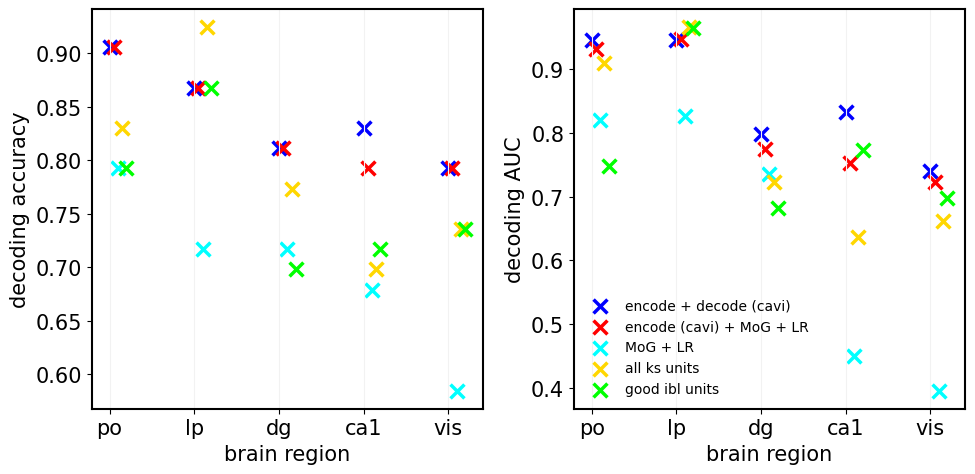

In [137]:
x = [0, 2, 4, 6, 8]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.scatter(x, enc_dec_acc, marker='x', s=100, c='blue', linewidth=2.5)
ax1.scatter(x+np.ones_like(x)*.1, enc_mog_acc, marker='x', s=100, c = 'red', linewidth=2.5)
ax1.scatter(x+np.ones_like(x)*.2, mog_acc, s=100, marker='x', c='cyan', linewidth=2.5)
ax1.scatter(x+np.ones_like(x)*.3, sorted_all_acc, marker='x', s=100, c = 'gold', linewidth=2.5)
ax1.scatter(x+np.ones_like(x)*.4, good_units_acc, marker='x', s=100, c = 'lime', linewidth=2.5)

ax1.set_xticks(x, rois)
ax1.grid(axis='x', color='.95')
ax1.set_xlabel('brain region')
ax1.set_ylabel('decoding accuracy')

ax2.scatter(x, enc_dec_auc, marker='x', s=100, c='blue', linewidth=2.5, label='encode + decode (cavi)')
ax2.scatter(x+np.ones_like(x)*.1, enc_mog_auc, marker='x', s=100, c = 'red', linewidth=2.5, label='encode (cavi) + MoG + LR')
ax2.scatter(x+np.ones_like(x)*.2, mog_auc, s=100, marker='x', c='cyan', linewidth=2.5, label='MoG + LR')
ax2.scatter(x+np.ones_like(x)*.3, sorted_all_auc, marker='x', s=100, c = 'gold', linewidth=2.5, label='all ks units')
ax2.scatter(x+np.ones_like(x)*.4, good_units_auc, marker='x', s=100, c = 'lime', linewidth=2.5, label='good ibl units')

ax2.set_xticks(x, rois)
ax2.grid(axis='x', color='.95')
ax2.set_xlabel('brain region')
ax2.set_ylabel('decoding AUC')
ax2.legend(loc='lower left', frameon=False, ncol=1)
plt.tight_layout()
# plt.savefig('perf_compare_regional.png', dpi=300)
plt.show()

In [21]:
enc_Ws = np.vstack([W_train, W_test])
enc_Ws_left = enc_Ws[choices.argmax(1) == 0].mean(0)
enc_Ws_right = enc_Ws[choices.argmax(1) == 1].mean(0)
enc_Ws_diff = enc_Ws_left - enc_Ws_right

orig_Ws = clusterless_neural_data.copy()
orig_Ws_left = orig_Ws[choices.argmax(1) == 0].mean(0)
orig_Ws_right = orig_Ws[choices.argmax(1) == 1].mean(0)
orig_Ws_diff = orig_Ws_left - orig_Ws_right

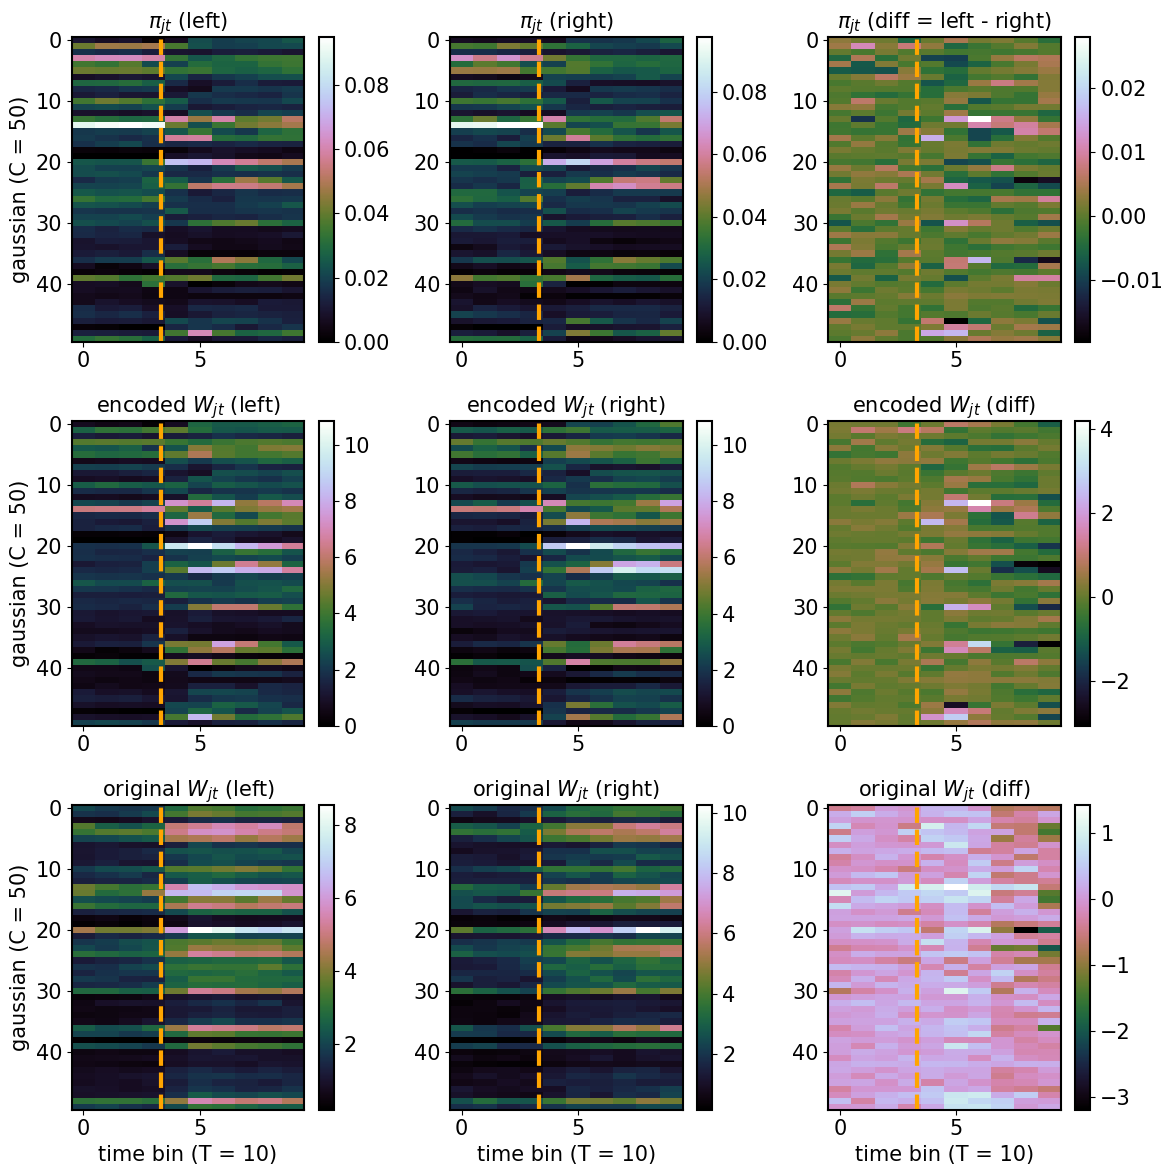

In [22]:
fig, axes = plt.subplots(3,3, figsize=(12, 12))

f1 = axes[0,0].imshow(enc_pis[:,:,0], aspect='auto', cmap='cubehelix')
axes[0,0].axvline((0.5/1.5)*10, linestyle='--', c='orange', linewidth=3)
axes[0,0].set_title('$\pi_{jt}$ (left)')
axes[0,0].set_ylabel('gaussian (C = 50)')
fig.colorbar(f1, ax=axes[0,0])

f2 = axes[0,1].imshow(enc_pis[:,:,1], aspect='auto', cmap='cubehelix')
axes[0,1].axvline((0.5/1.5)*10, linestyle='--', c='orange', linewidth=3)
axes[0,1].set_title(r'$\pi_{jt}$ (right)')
fig.colorbar(f2, ax=axes[0,1]);

f3 = axes[0,2].imshow(enc_pis[:,:,0] - enc_pis[:,:,1], aspect='auto', cmap='cubehelix')
axes[0,2].axvline((0.5/1.5)*10, linestyle='--', c='orange', linewidth=3)
axes[0,2].set_title(r'$\pi_{jt}$ (diff = left - right)')
fig.colorbar(f3, ax=axes[0,2]);

f4 = axes[1,0].imshow(enc_Ws_left.T, aspect='auto', cmap='cubehelix')
axes[1,0].axvline((0.5/1.5)*10, linestyle='--', c='orange', linewidth=3)
axes[1,0].set_ylabel('gaussian (C = 50)')
axes[1,0].set_title('encoded $W_{jt}$ (left)')
fig.colorbar(f4, ax=axes[1,0]);

f5 = axes[1,1].imshow(enc_Ws_right.T, aspect='auto', cmap='cubehelix')
axes[1,1].axvline((0.5/1.5)*10, linestyle='--', c='orange', linewidth=3)
axes[1,1].set_title('encoded $W_{jt}$ (right)')
fig.colorbar(f5, ax=axes[1,1]);

f6 = axes[1,2].imshow(enc_Ws_diff.T, aspect='auto', cmap='cubehelix')
axes[1,2].axvline((0.5/1.5)*10, linestyle='--', c='orange', linewidth=3)
axes[1,2].set_title('encoded $W_{jt}$ (diff)')
fig.colorbar(f6, ax=axes[1,2]);

f7 = axes[2,0].imshow(orig_Ws_left, aspect='auto', cmap='cubehelix')
axes[2,0].axvline((0.5/1.5)*10, linestyle='--', c='orange', linewidth=3)
axes[2,0].set_xlabel('time bin (T = 10)')
axes[2,0].set_ylabel('gaussian (C = 50)')
axes[2,0].set_title('original $W_{jt}$ (left)')
fig.colorbar(f7, ax=axes[2,0]);

f8 = axes[2,1].imshow(orig_Ws_right, aspect='auto', cmap='cubehelix')
axes[2,1].axvline((0.5/1.5)*10, linestyle='--', c='orange', linewidth=3)
axes[2,1].set_xlabel('time bin (T = 10)')
axes[2,1].set_title('original $W_{jt}$ (right)')
fig.colorbar(f8, ax=axes[2,1]);

f9 = axes[2,2].imshow(orig_Ws_diff, aspect='auto', cmap='cubehelix')
axes[2,2].axvline((0.5/1.5)*10, linestyle='--', c='orange', linewidth=3)
axes[2,2].set_xlabel('time bin (T = 10)')
axes[2,2].set_title('original $W_{jt}$ (diff)')
fig.colorbar(f9, ax=axes[2,2]);

plt.tight_layout()
plt.savefig('compare_weight_matrices.png', dpi=300)
